# 🎬 Face Recognition Project – Data Exploration

Welcome! In this notebook, we explore video data for a face recognition pipeline. We'll extract frames from a roundtable interview of actresses to prepare our dataset for face embedding generation.

**Participants:** Angelina Jolie, Zendaya, Demi Moore, Tilda Swinton, Zoe Saldaña, Mikey Madison  
**Video file:** `actress_roundtable.mp4`

This step is crucial as it ensures the quality, balance, and readiness of data used in our model pipeline. Let's begin!

Let's first import the libraries we'll be using.

In [1]:
import sys
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from IPython.display import Video
from datetime import timedelta

In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("PIL version : ", PIL.__version__)
print("cv2 version : ", cv2.__version__)

Platform: linux
Python version: 3.11.0 (main, Nov 15 2022, 20:12:54) [GCC 10.2.1 20210110]
---
PIL version :  10.2.0
cv2 version :  4.10.0


## Load & Display the Interview Video

We’ll begin by loading the video to inspect its format and ensure it plays as expected.

In [3]:
video_path = Path("actress_roundtable.mp4")

# Preview video if running in a notebook interface
if video_path.exists():
    display(Video(video_path, width=400))
else:
    print("Video file not found at", video_path)


## Exploring the Video Properties

Let’s examine the basic attributes of our video: frame rate, total number of frames, and resolution (width × height).


In [4]:
cap = cv2.VideoCapture(str(video_path))

fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = frame_count / fps
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Frame Rate (FPS): {fps}")
print(f"Total Frames: {frame_count}")
print(f"Duration (seconds): {duration:.2f} (~{timedelta(seconds=int(duration))})")
print(f"Resolution: {width} x {height}")


Frame Rate (FPS): 23.97602723669996
Total Frames: 84476
Duration (seconds): 3523.35 (~0:58:43)
Resolution: 1920 x 1080


## Displaying the First Frame

This helps us visually verify that the video is read properly and the resolution looks good.


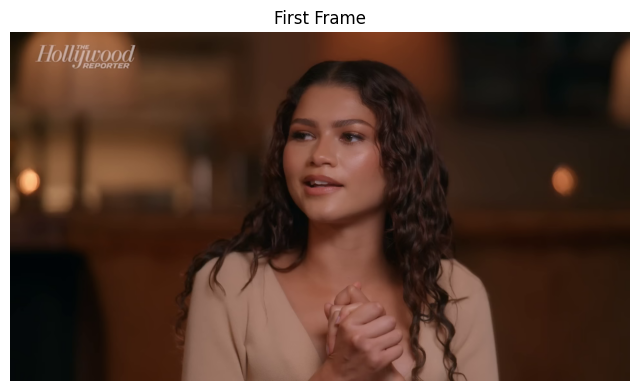

In [5]:
success, first_frame = cap.read()
if success:
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    plt.title("First Frame")
    plt.axis("off")
    plt.show()
else:
    print("Failed to read the first frame.")


In [6]:
height, width, channel = first_frame.shape

print("frames height : ", height)
print("frames width : ", width)
print("frames channel : ", channel)

frames height :  1080
frames width :  1920
frames channel :  3


## Extracting Frames – Clean & Efficient

Instead of capturing every frame, we extract one frame per second to balance variety and storage.

We'll save them in a directory called `extracted_frames`.

In [7]:
frames_dir = Path("video_data/extracted_frames")
frames_dir.mkdir(parents=True, exist_ok=True)

frame_interval = int(fps)  # Extract 1 frame per second
extracted = 0

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

for frame_num in range(0, frame_count, frame_interval):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    if not ret:
        continue
    frame_filename = frames_dir / f"frame_{frame_num:05d}.jpg"
    cv2.imwrite(str(frame_filename), frame)
    extracted += 1
cap.release()


In [8]:
frame_files = list(frames_dir.glob("*.jpg"))
print(f"Total extracted frames: {len(frame_files)}")


Total extracted frames: 3673


## Visualizing Sample Extracted Frames

Let’s preview a few of the frames we've just extracted to confirm face visibility and quality.


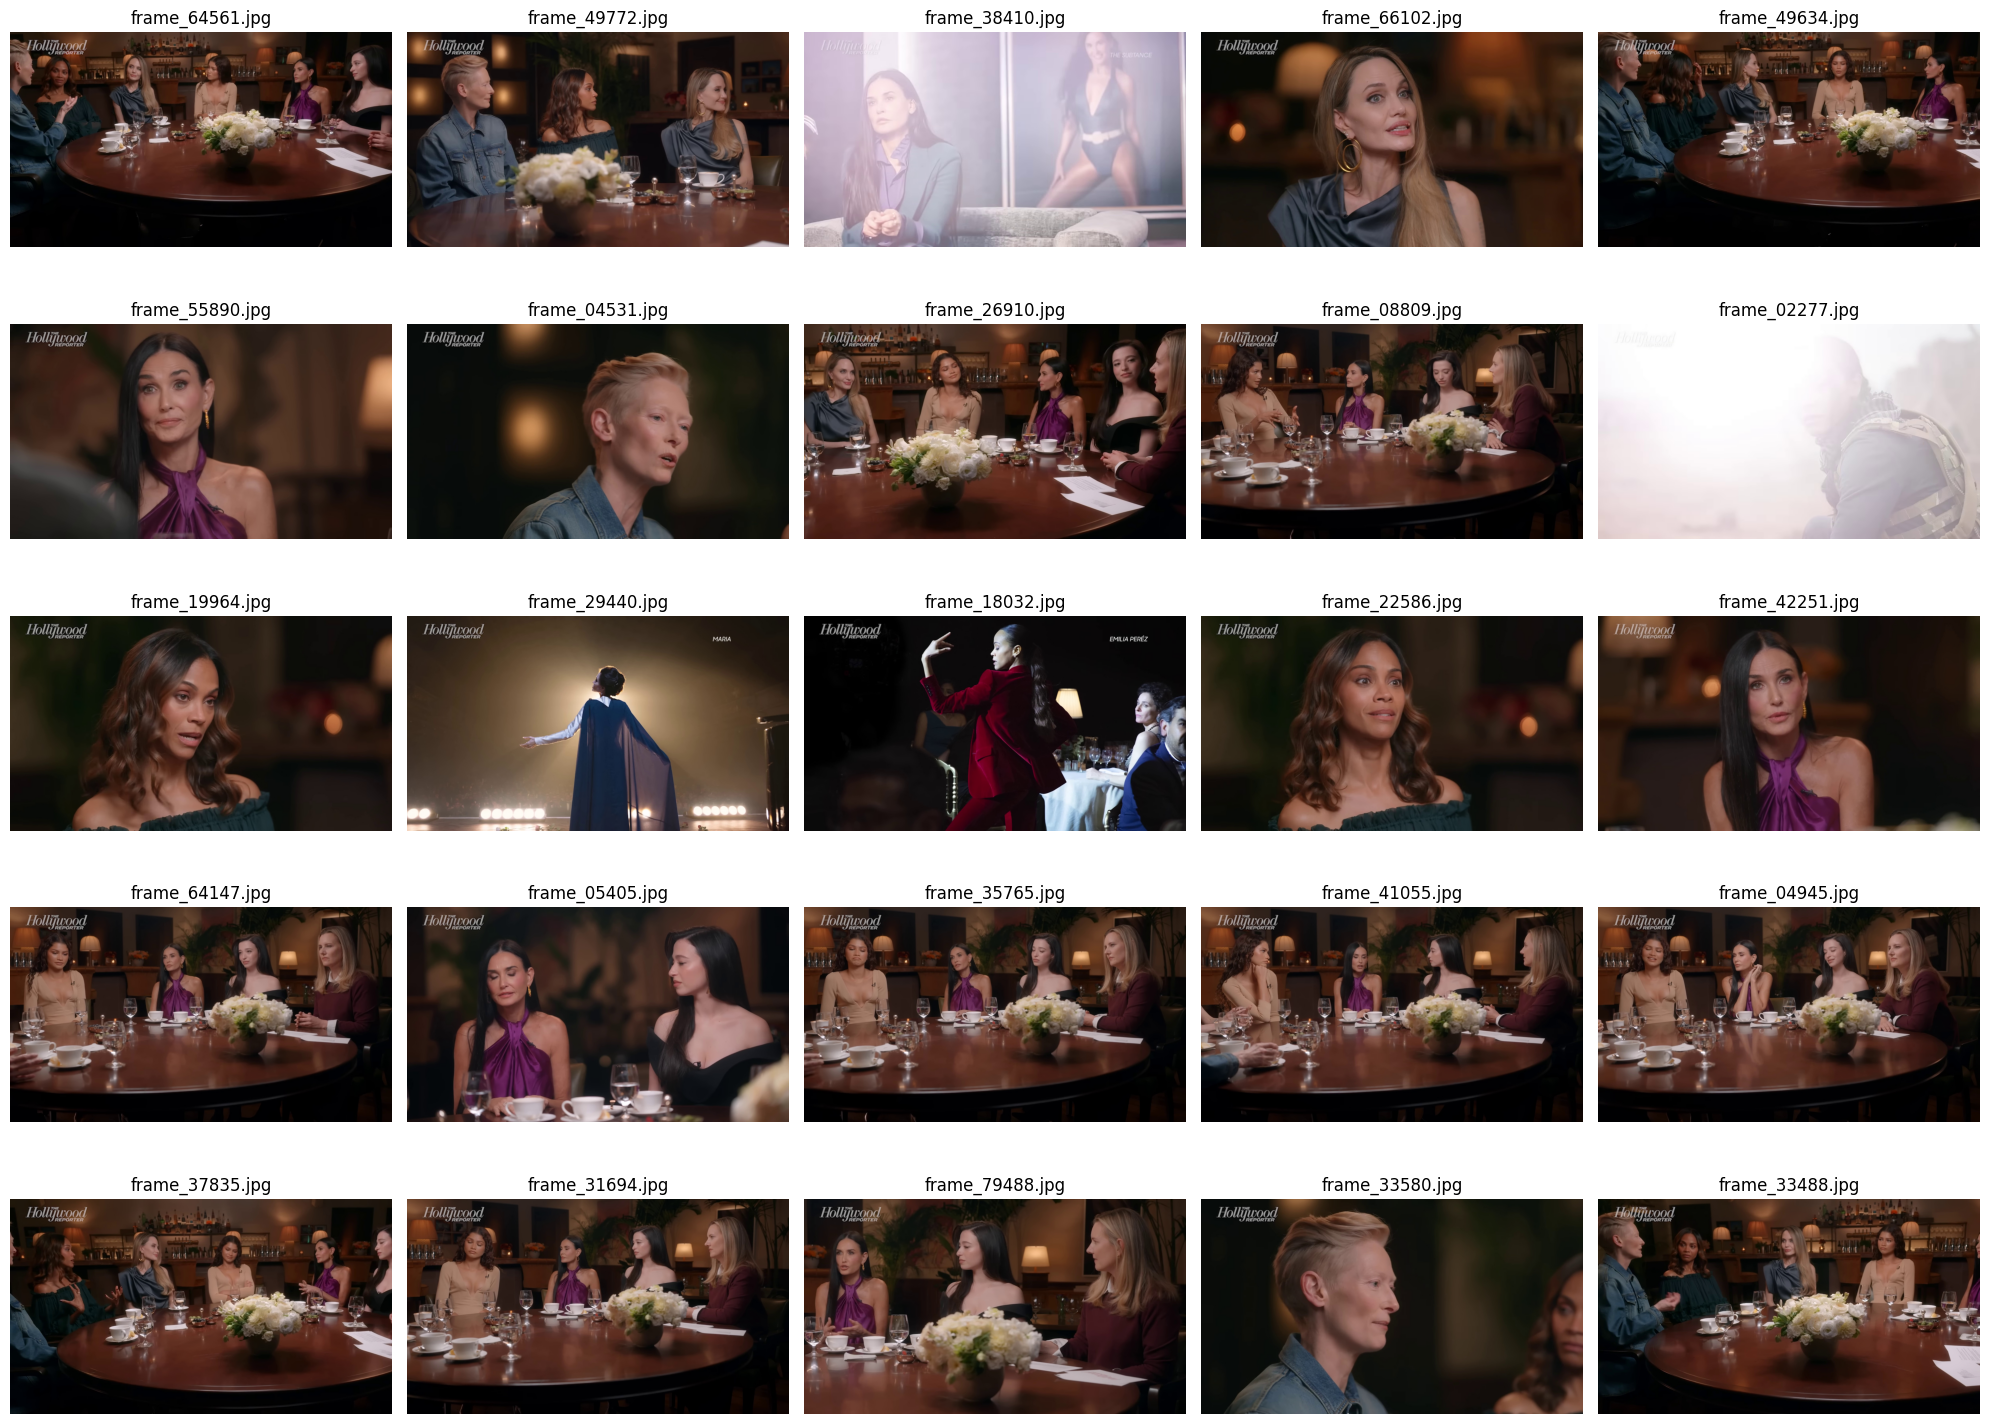

In [9]:
def display_sample_images(images, rows=5, cols=5, figsize=(20, 15)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    for img_path, ax in zip(images[: rows * cols], axes):
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.axis("off")
        ax.set_title(img_path.name)
    plt.tight_layout()
    plt.show()

display_sample_images(frame_files)


## Frame Histogram Analysis – Brightness Distribution

To understand the lighting conditions across frames, we’ll calculate the average brightness of each frame.

This helps identify:
- Whether faces are well-lit across the dataset
- Any significant fluctuations due to lighting/cuts


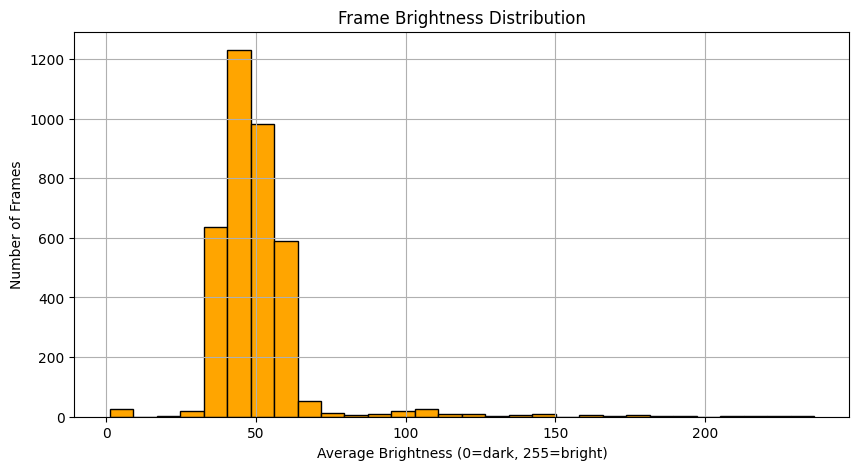

In [10]:
def compute_brightness(image_path):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    return img.mean()

brightness_values = [compute_brightness(f) for f in frame_files]

plt.figure(figsize=(10, 5))
plt.hist(brightness_values, bins=30, color='orange', edgecolor='black')
plt.title("Frame Brightness Distribution")
plt.xlabel("Average Brightness (0=dark, 255=bright)")
plt.ylabel("Number of Frames")
plt.grid(True)
plt.show();


## Key Insight: Lighting Profile of the Video

From the brightness histogram, we can infer that the video has a consistent lighting environment. The majority of frames fall within a moderate brightness range (40–60), indicating indoor or controlled lighting conditions typical of studio interviews.

This relatively narrow range of brightness can help facial recognition models by providing consistent lighting across frames, reducing the variability introduced by shadows or overexposure. However, the low presence of bright frames may affect generalizability to environments with more direct lighting, like outdoor scenes or strong spotlights.


## Summary

- We successfully loaded the interview video and explored key metadata.
- Extracted 1 frame per second, balancing performance and visual diversity.
- Saved and visualized a sample of frames — ready for face detection & embedding!

Next: We'll generate face embeddings using MTCNN + ResNet and save them for inference in our Flask app.
